In [6]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
print('Running openCV: ', cv2.__version__)


plt.rcParams['figure.figsize'] = (50,10)
#%matplotlib inline

%load_ext autoreload
%autoreload 2

Running openCV:  4.4.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Подготовка данных

In [7]:
nek = pd.read_csv('C:/Users/Николай/Desktop/Project/table_nek.csv')
scan = pd.read_csv('C:/Users/Николай/Desktop/Project/table_scan.csv')

downloaded_days = ['02', '03', '04', '05', '06', '07', '09', '13',
                   '15', '16', '17', '18', '19', '20', '21', '22',
                   '23', '24', '25', '26', '27', '30', '31']

In [8]:
nek['sort'].value_counts()

Бал-сы пр. хв.п. и см. хв. п.    1571
Балансы березовые                 355
Балансы еловые                    143
Балансы сосновые                   25
Name: sort, dtype: int64

In [9]:
classes_2cl = ('хвойные', 'березовые')
classes_4cl = ('Бал-сы пр. хв.п. и см. хв. п.', 'Балансы березовые',
               'Балансы еловые', 'Балансы сосновые')

In [10]:
def choose_class_2cl(str):
    if str == 'Балансы березовые':
        return 1
    return 0

def choose_class_4cl(str):
    if str == 'Балансы березовые':
        return 1
    elif str == 'Бал-сы пр. хв.п. и см. хв. п.':
        return 0
    elif str == 'Балансы еловые':
        return 2
    elif str == 'Балансы сосновые':
        return 3

def prepare_df(df, num_classes=2, downloaded_days=None):
    
    df['front_frames'] = df['front_frames'].apply(lambda x: x[1:-2].split()[len(x.split()) // 2][1:-2])
    df['path'] = df['path'].apply(lambda x: x.replace('scan_track_video/2020_01', 'part_1'))
    df['path'] = df[['path', 'front_frames']].apply(lambda x: '/FrontJPG/'.join(x), axis=1)
    df['day'] = df['path'].apply(lambda x: x[7:9])
    
    if num_classes == 2:
        df['sort'] = df['sort'].apply(lambda x: choose_class_2cl(x))
    else:
        df['sort'] = df['sort'].apply(lambda x: choose_class_4cl(x))
    
    if downloaded_days is not None:
        df = df[df['day'].isin(downloaded_days)]
    
    df.drop(columns=['truck_N', 'trailer_N', 'pack_N', 'front_frames', 'datetime'], inplace=True)
    return df

nek = prepare_df(nek, 4, downloaded_days)

In [11]:
nek['sort'].value_counts()

0    1223
1     252
2      71
3      19
Name: sort, dtype: int64

# Будем обучать модели

In [12]:
import torch
import torchvision.transforms as T
import torchvision
import datetime
from PIL import Image

from sklearn.model_selection import train_test_split

In [13]:
nek['sort'].value_counts()

0    1223
1     252
2      71
3      19
Name: sort, dtype: int64

In [14]:
nek.head()

,pack_id,path,sort,length,width,height,k,volume,day
0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,1,600.0,236.0,182.0,0.54,13.916448,21
1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,1,600.0,236.0,180.0,0.54,13.763520,21
2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,0,300.0,226.0,176.0,0.64,7.636992,21
3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,0,300.0,226.0,186.0,0.60,7.566480,21
4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,0,300.0,226.0,170.0,0.60,6.915600,21


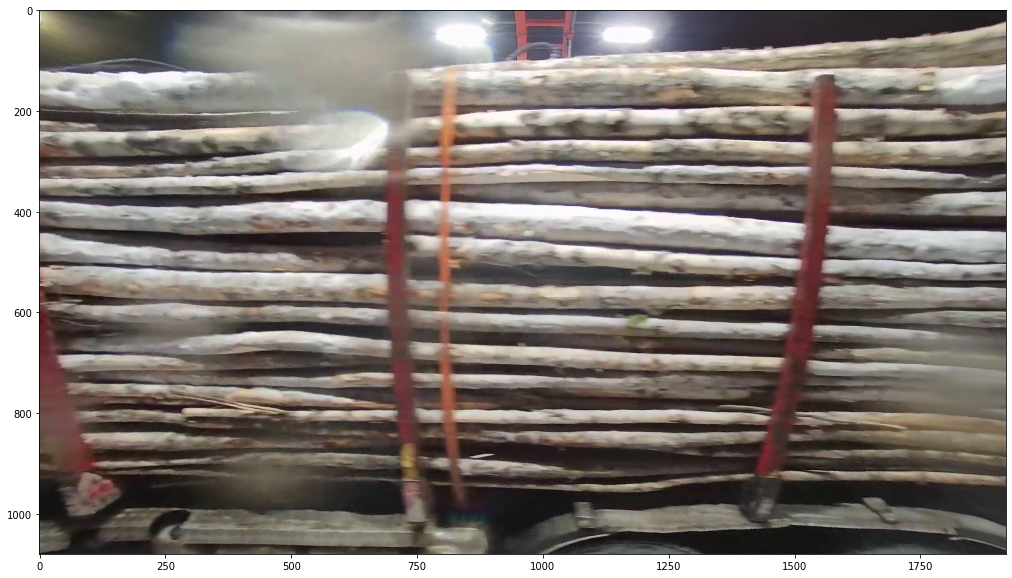

In [15]:
img = Image.open('part_1/07/033515_М274КР10/FrontJPG/front12.jpg')
plt.imshow(img)

In [16]:
train, test = train_test_split(nek, test_size=0.2)

В качестве предобработки вырезаем часть изображения и делаем нормализацию

In [17]:
input_size = 224
batch_size = 32

transform = T.Compose(
           [T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
            ])

class myDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row['path'])
        area = (750, 180, 1400, 970)
        image = image.crop(area)
        label = row['sort']
        if self.transform:
            image = self.transform(image)
        
        return (image, label)
    
dataset_train = myDataset(train, transform)
dataset_test = myDataset(test, transform)

dataloaders_dict = {'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
                    'val': torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
device

device(type='cuda', index=0)

In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(dataloaders_dict['train'])
images, labels = dataiter.next()

In [19]:
import torchvision.models as models
import time
import copy

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_err_history = []
    train_err_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_err_history.append(epoch_loss)
            if phase == 'train':
                train_err_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_err_history, train_err_history

In [ ]:
feature_extract = True
num_classes = 4
model_ft = models.resnet34(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

In [14]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [23]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [15]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 50
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.8107 Acc: 0.7332
val Loss: 0.5871 Acc: 0.7923

Epoch 1/49
----------
train Loss: 0.5726 Acc: 0.8091
val Loss: 0.5163 Acc: 0.8051

Epoch 2/49
----------
train Loss: 0.5102 Acc: 0.8355
val Loss: 0.4655 Acc: 0.8147

Epoch 3/49
----------
train Loss: 0.4827 Acc: 0.8307
val Loss: 0.4275 Acc: 0.8786

Epoch 4/49
----------
train Loss: 0.4315 Acc: 0.8594
val Loss: 0.4069 Acc: 0.8435

Epoch 5/49
----------
train Loss: 0.4086 Acc: 0.8650
val Loss: 0.3892 Acc: 0.8594

Epoch 6/49
----------
train Loss: 0.3963 Acc: 0.8730
val Loss: 0.3663 Acc: 0.8754

Epoch 7/49
----------
train Loss: 0.3758 Acc: 0.8794
val Loss: 0.3538 Acc: 0.8786

Epoch 8/49
----------
train Loss: 0.3691 Acc: 0.8898
val Loss: 0.3466 Acc: 0.8722

Epoch 9/49
----------
train Loss: 0.3434 Acc: 0.8906
val Loss: 0.3405 Acc: 0.8754

Epoch 10/49
----------
train Loss: 0.3454 Acc: 0.8890
val Loss: 0.3435 Acc: 0.8722

Epoch 11/49
----------
train Loss: 0.3277 Acc: 0.8866
val Loss: 0.3291 Acc: 0.8914

Ep

[]

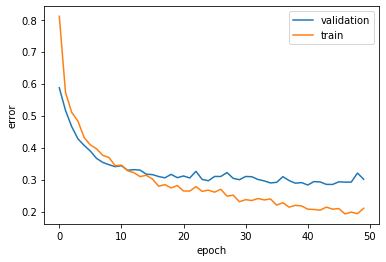

In [18]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [19]:
torch.save(model_ft, 'models/resnet18.pth')

# resnet 101

In [15]:
feature_extract = True
num_classes = 4
model_ft = models.resnet101(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

In [16]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [17]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 50
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.7815 Acc: 0.7404
val Loss: 0.5222 Acc: 0.8147

Epoch 1/49
----------
train Loss: 0.6390 Acc: 0.7764
val Loss: 0.5030 Acc: 0.8658

Epoch 2/49
----------
train Loss: 0.5966 Acc: 0.7995
val Loss: 0.4472 Acc: 0.8211

Epoch 3/49
----------
train Loss: 0.5402 Acc: 0.8067
val Loss: 0.4053 Acc: 0.8530

Epoch 4/49
----------
train Loss: 0.5081 Acc: 0.8259
val Loss: 0.3973 Acc: 0.8498

Epoch 5/49
----------
train Loss: 0.4811 Acc: 0.8275
val Loss: 0.3852 Acc: 0.8946

Epoch 6/49
----------
train Loss: 0.4665 Acc: 0.8482
val Loss: 0.3557 Acc: 0.8978

Epoch 7/49
----------
train Loss: 0.4553 Acc: 0.8522
val Loss: 0.3396 Acc: 0.8754

Epoch 8/49
----------
train Loss: 0.4323 Acc: 0.8610
val Loss: 0.3349 Acc: 0.8850

Epoch 9/49
----------
train Loss: 0.4146 Acc: 0.8610
val Loss: 0.3248 Acc: 0.9042

Epoch 10/49
----------
train Loss: 0.4074 Acc: 0.8682
val Loss: 0.3146 Acc: 0.9073

Epoch 11/49
----------
train Loss: 0.3963 Acc: 0.8730
val Loss: 0.3115 Acc: 0.9137

Ep

[]

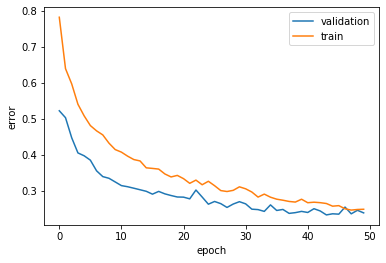

In [18]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [19]:
torch.save(model_ft, 'models/resnet101.pth')

# Densenet 201

In [16]:
feature_extract = True
num_classes = 4
model_ft = models.densenet201(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

In [17]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [18]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 50
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.7573 Acc: 0.7716
val Loss: 0.6021 Acc: 0.7859

Epoch 1/49
----------
train Loss: 0.6083 Acc: 0.7851
val Loss: 0.5375 Acc: 0.8019

Epoch 2/49
----------
train Loss: 0.5488 Acc: 0.8195
val Loss: 0.5266 Acc: 0.7891

Epoch 3/49
----------
train Loss: 0.5129 Acc: 0.8203
val Loss: 0.4695 Acc: 0.8307

Epoch 4/49
----------
train Loss: 0.4703 Acc: 0.8435
val Loss: 0.4492 Acc: 0.8562

Epoch 5/49
----------
train Loss: 0.4536 Acc: 0.8538
val Loss: 0.4399 Acc: 0.8850

Epoch 6/49
----------
train Loss: 0.4297 Acc: 0.8618
val Loss: 0.4134 Acc: 0.8722

Epoch 7/49
----------
train Loss: 0.4092 Acc: 0.8714
val Loss: 0.4022 Acc: 0.8754

Epoch 8/49
----------
train Loss: 0.3871 Acc: 0.8738
val Loss: 0.3823 Acc: 0.8946

Epoch 9/49
----------
train Loss: 0.3826 Acc: 0.8802
val Loss: 0.3879 Acc: 0.9010

Epoch 10/49
----------
train Loss: 0.3806 Acc: 0.8754
val Loss: 0.3708 Acc: 0.8754

Epoch 11/49
----------
train Loss: 0.3558 Acc: 0.8898
val Loss: 0.3662 Acc: 0.9010

Ep

[]

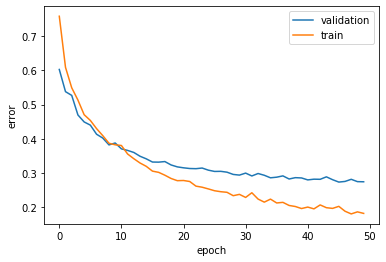

In [19]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [20]:
torch.save(model_ft, 'models/densenet201.pth')

**100 эпох**

In [15]:
feature_extract = True
num_classes = 4
model_ft = models.densenet201(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

In [16]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0004, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [17]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 100
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 0.8306 Acc: 0.7141
val Loss: 0.5889 Acc: 0.8019

Epoch 1/99
----------
train Loss: 0.6308 Acc: 0.7827
val Loss: 0.5370 Acc: 0.8019

Epoch 2/99
----------
train Loss: 0.5754 Acc: 0.7891
val Loss: 0.4991 Acc: 0.8243

Epoch 3/99
----------
train Loss: 0.5421 Acc: 0.8059
val Loss: 0.4698 Acc: 0.8466

Epoch 4/99
----------
train Loss: 0.5066 Acc: 0.8259
val Loss: 0.4550 Acc: 0.8754

Epoch 5/99
----------
train Loss: 0.4798 Acc: 0.8490
val Loss: 0.4284 Acc: 0.8786

Epoch 6/99
----------
train Loss: 0.4689 Acc: 0.8411
val Loss: 0.4131 Acc: 0.8850

Epoch 7/99
----------
train Loss: 0.4505 Acc: 0.8538
val Loss: 0.4261 Acc: 0.8978

Epoch 8/99
----------
train Loss: 0.4360 Acc: 0.8698
val Loss: 0.3866 Acc: 0.8786

Epoch 9/99
----------
train Loss: 0.4050 Acc: 0.8746
val Loss: 0.3759 Acc: 0.8978

Epoch 10/99
----------
train Loss: 0.3924 Acc: 0.8762
val Loss: 0.3730 Acc: 0.9073

Epoch 11/99
----------
train Loss: 0.3827 Acc: 0.8826
val Loss: 0.3643 Acc: 0.9073

Ep

[]

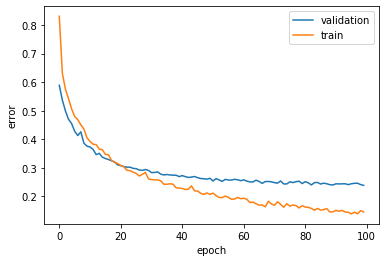

In [18]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [19]:
torch.save(model_ft, 'models/densenet201_100.pth')

In [20]:
model_ft = torch.load('models/densenet201_100.pth')

# Матрица ошибок 4 класса

In [24]:
from sklearn.metrics import confusion_matrix

nb_classes = 4

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

[[248   1   0   0]
 [  2  41   0   0]
 [  6   0   9   0]
 [  4   0   0   2]]


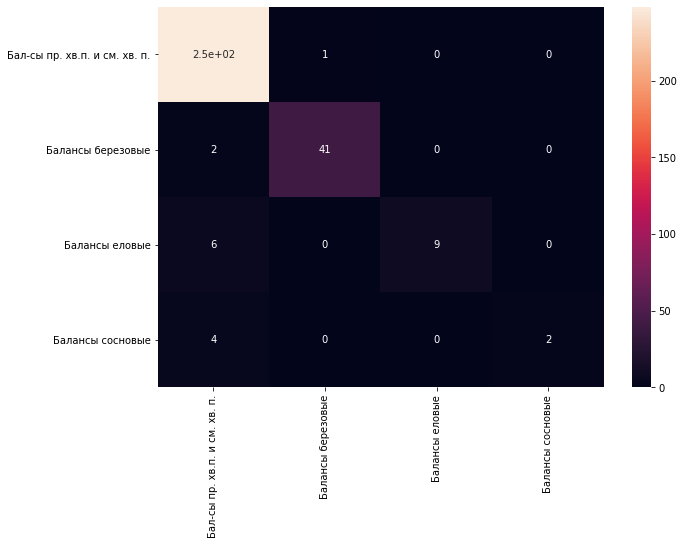

In [29]:
import seaborn as sn

df_cm = pd.DataFrame(conf_mat, index = ['Бал-сы пр. хв.п. и см. хв. п.',
                                        'Балансы березовые',
                                        'Балансы еловые',
                                        'Балансы сосновые'],
                      columns = ['Бал-сы пр. хв.п. и см. хв. п.',
                                 'Балансы березовые',
                                 'Балансы еловые',
                                 'Балансы сосновые'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Матрица ошибок 2 класса

In [37]:
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        
        preds = preds.view(-1).cpu()
        classes = classes.view(-1).cpu()
        preds[preds != 1] = 0
        classes[classes != 1] = 0

        # Append batch prediction results
        predlist=torch.cat([predlist,preds])
        lbllist=torch.cat([lbllist,classes])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

[[269   1]
 [  2  41]]


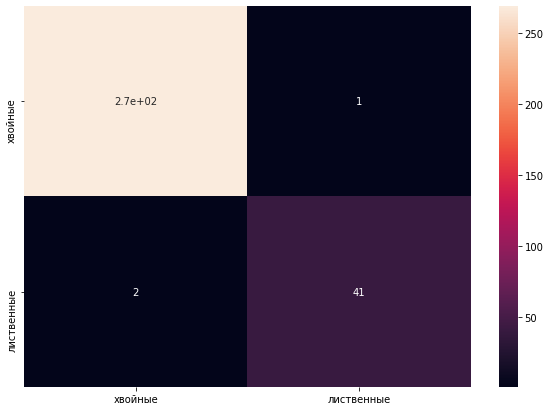

In [38]:
df_cm = pd.DataFrame(conf_mat, index = ['хвойные',
                                        'лиственные'],
                      columns = ['хвойные',
                                 'лиственные'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Densenet 121

In [15]:
feature_extract = True
num_classes = 4
model_ft = models.densenet121(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = torch.nn.Linear(num_ftrs, num_classes)
input_size = 224

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Николай/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


In [16]:
import torch.optim as optim

model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0005, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [17]:
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 50
model_ft, hist_val_acc, hist_val_err, hist_train_err = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.7814 Acc: 0.7484
val Loss: 0.6348 Acc: 0.7732

Epoch 1/49
----------
train Loss: 0.6003 Acc: 0.7883
val Loss: 0.5779 Acc: 0.8307

Epoch 2/49
----------
train Loss: 0.5508 Acc: 0.8107
val Loss: 0.5325 Acc: 0.8339

Epoch 3/49
----------
train Loss: 0.5067 Acc: 0.8251
val Loss: 0.4990 Acc: 0.8498

Epoch 4/49
----------
train Loss: 0.4774 Acc: 0.8458
val Loss: 0.4785 Acc: 0.8594

Epoch 5/49
----------
train Loss: 0.4527 Acc: 0.8506
val Loss: 0.4673 Acc: 0.8530

Epoch 6/49
----------
train Loss: 0.4379 Acc: 0.8554
val Loss: 0.4462 Acc: 0.8690

Epoch 7/49
----------
train Loss: 0.4218 Acc: 0.8666
val Loss: 0.4336 Acc: 0.8626

Epoch 8/49
----------
train Loss: 0.4064 Acc: 0.8586
val Loss: 0.4266 Acc: 0.8626

Epoch 9/49
----------
train Loss: 0.3875 Acc: 0.8682
val Loss: 0.4157 Acc: 0.8626

Epoch 10/49
----------
train Loss: 0.3838 Acc: 0.8802
val Loss: 0.4045 Acc: 0.8626

Epoch 11/49
----------
train Loss: 0.3767 Acc: 0.8802
val Loss: 0.3953 Acc: 0.8594

Ep

[]

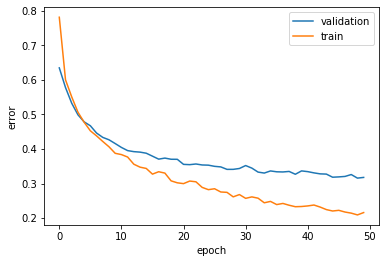

In [18]:
plt.plot(hist_val_err)
plt.plot(hist_train_err)
plt.legend(['validation', 'train'], loc='best')
plt.xlabel('epoch')
plt.ylabel('error')
plt.plot()

In [19]:
torch.save(model_ft, 'models/densenet121.pth')